# Step 14 - Testing Combined Kriging - Timing 

In [34]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import gempy as gp

# Importing auxiliary libraries
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import time

from scipy import sparse
from scipy.sparse.linalg import splu

from skimage import measure
from scipy.spatial.distance import cdist

In [35]:
def updt(total, progress):
    """
    Displays or updates a console progress bar.

    Original source: https://stackoverflow.com/a/15860757/1391441
    """
    barLength, status = 20, ""
    progress = float(progress) / float(total)
    if progress >= 1.:
        progress, status = 1, "\r\n"
    block = int(round(barLength * progress))
    text = "\r[{}] {:.0f}% {}".format(
        "#" * block + "-" * (barLength - block), round(progress * 100, 0),
        status)
    sys.stdout.write(text)
    sys.stdout.flush()


In [36]:
import matplotlib as mpl

# define the colormap
cmap = plt.cm.PuBu_r
# extract all colors
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,40,8)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [37]:
def get_distance_matrices(dist_matrix, n, prop_data):
    """
    Method to get closest points out of distance matrix calculated beforehand.
    Args:
        dist_matrix (np.array): matrix of distances between existing property data points
        n(int): number of closest points used 
        prop_data(np.array)(n,2): array containing indexes of property data in grid and corresponding values
    Returns
        dist_close_all_to_all: 
        dist_close_target_to_all:
    """
    #index of target point
    target_point = len(dist_matrix)-1
    
    # check for n closest points in matrix (minimum distance values) and sort the resulting index array
    ind = np.argpartition(dist_matrix[target_point], n+1)[:n+1]
    sort_ind = np.sort(ind)
    
    # create new property array to match property data to correct indices
    ind_aux_prop = sort_ind[:len(sort_ind)-1]
    closest_prop_data = prop_data[1][ind_aux_prop]

    # extract distances from target point (row of target index - now last row of matrix) without last entry (target)
    dist_close_target_to_all = dist_matrix[target_point][sort_ind]
    dist_close_target_to_all = dist_close_target_to_all[:len(dist_close_target_to_all)-1]
    
    # extract distance each to each for those closest points, delete target point index row and column
    dist_close_all_to_all = dist_matrix[np.ix_(sort_ind[:len(sort_ind)-1],sort_ind[:len(sort_ind)-1])]
        
    return dist_close_target_to_all, dist_close_all_to_all, closest_prop_data

In [38]:
def precalculate_distances(prop_data, sgs_check, grid_coord):
    
    # order grid by indices given in prop_data[0] and sgs check
    aux = np.append(prop_data[0], sgs_check)
    grid_reordered = grid_coord[aux]
    
    # perform cdist
    dist_matrix = cdist(grid_reordered, grid_reordered)
        
    return dist_matrix

In [39]:
def ordinary_kriging(target_point, a, b, prop):
    #def ordinary_kriging(point, data):
    
    # empty matrix building
    shape = len(a)
    C = np.zeros((shape+1, shape+1))
    c = np.zeros((shape+1))
    w = np.zeros((shape+1))
    
    # Faster matrix building approach, no loops
    C[:shape, :shape] = gaussian_variogram_model(b)
    c[:shape] = gaussian_variogram_model(a)
    
    # matrix setup - compare pykrige, special for OK
    np.fill_diagonal(C, 0)
    C[shape, :] = 1.0
    C[:, shape] = 1.0
    C[shape, shape] = 0.0  
    c[shape] = 1.0

    # Solve Kriging equations
    w = np.linalg.solve(C,c)
    
    # SGS version - need to get mean and std
    #result = np.random.normal(np.sum(w[:shape] * prop), scale=np.sqrt(w[shape]-gaussian_variogram_model(0)+np.sum(w[:shape]*c[:shape])))
    
    # direct version, calculating result from weights.
    result = np.sum(w[:shape] * prop)
    
    return result

In [40]:
def sgs(prop_data, grid_coord):
    
    # just for progress bar
    runs = len(grid_coord)-len(prop_data[0])
    
    # for timing purposes
    time_prec = 0
    time_sub = 0
    time_dist = 0
    time_krig = 0
    
    # create array to go through SGS, only containing indices of grid points without data
    sgs_check = np.arange(0,len(grid_coord))
    sgs_check = np.delete(sgs_check, prop_data[0])
    
    # randomize it to predefine SGS way
    np.random.shuffle(sgs_check)
    
    # precalculate distances
    t_pre1 = time.time()
    dist_matrix_sgs_order = precalculate_distances(prop_data, sgs_check, grid_coord)
    t_pre2 = time.time()
    print("distance precalculation:", t_pre2-t_pre1)
    
    # set initial length of property data frame
    start = len(prop_data[0])
    
    for i in range(0, len(sgs_check)):
        
        # choose first point from sgs_check, as this is already randomized
        target_point = sgs_check[i]
        
        t0 = time.time()
        # extract submatrix required for distances
        submatrix = dist_matrix_sgs_order[0:start+i+1,0:start+i+1] 
        
        t1 = time.time()
        time_sub = time_sub+(t1-t0)
        # get closest distances
        a, b, prop = get_distance_matrices(submatrix, 4, prop_data)
        
        t2 = time.time()
        time_dist = time_dist+(t2-t1)
        # perform the Kriging interpolation on this point
        kriging_result = ordinary_kriging(target_point, a , b, prop) 
        
        t3 = time.time()
        time_krig = time_krig+(t3-t2)
        
        # add point to property data list
        prop_data = np.hstack((prop_data, ([[target_point], [kriging_result]])))
        prop_data = np.round(prop_data) # just for now
        
        #use of progress bar ...
        #updt(runs,i+1)
    
    # sort the results properly at the end - needs to be optimized for not rounding it 
    prop_data = np.round(prop_data) # just for now
    prop_data = sorted(np.swapaxes(prop_data,0,1), key=lambda row: row[0])
    prop_data = np.vstack(prop_data)
    prop_data = np.swapaxes(prop_data,0,1)
    
    print("submatrix extraction:", time_sub)
    print("distance Matrices:", time_dist)
    print("kriging calculation:", time_krig)
    
    return prop_data

In [41]:
def gaussian_variogram_model(d):
    range_ = 170
    sill = 40
    nugget = 10
    psill =sill-nugget
    gamma = psill * (1. - np.exp(-d**2./(range_)**2.))+nugget
    return gamma

## Simple Test

In [45]:
# simple test
a =np.arange(0,100,1)
b =np.arange(0,100,1)
xx,yy=np.meshgrid(a,b)
coord = np.vstack((xx.ravel(),yy.ravel()))
coord1 = np.swapaxes(coord,0,1)

vals = np.array([1,1,1,1,39,39,39,39])
inds = np.array([0,1,2,3,86,87,88,89])
prop_d = np.array((inds,vals))
dist_m = cdist(coord1, coord1)

In [51]:
result = sgs(prop_d, coord1)

distance precalculation: 1.0463793277740479
submatrix extraction: 0.010664939880371094
distance Matrices: 1.1237163543701172
kriging calculation: 0.7713108062744141


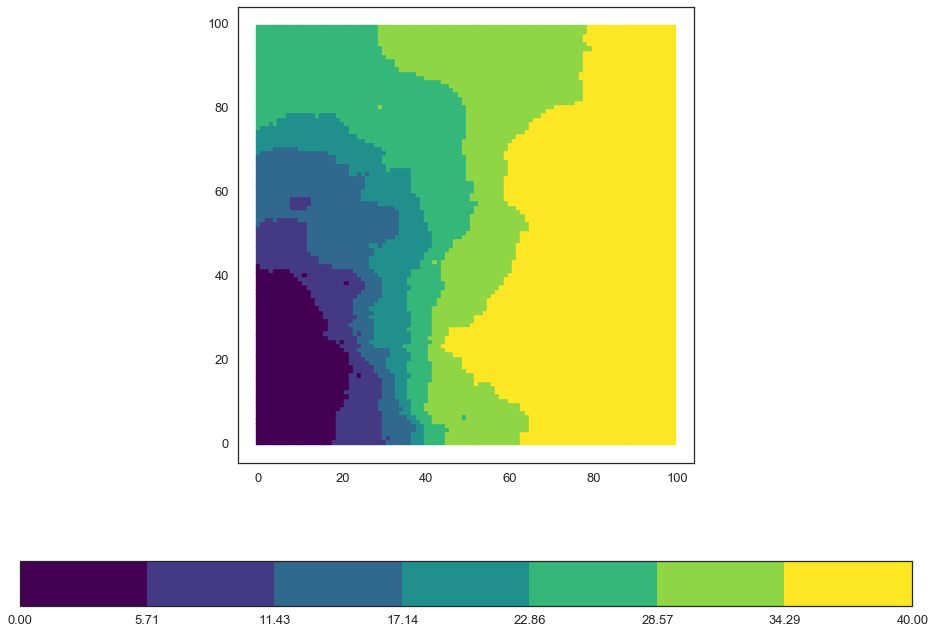

In [52]:
fig = plt.figure(figsize=(16,12))



a = plt.scatter(coord[0], coord[1], c=result[1], s=20, marker=',', cmap='viridis', norm=norm)
b = plt.scatter()

plt.axis('scaled')
fig.colorbar(a, orientation='horizontal')

## My testing model

In [26]:
# more complex test run with the data I used before
domain = pd.read_csv("domain3d.csv")
data = pd.read_csv("data3d.csv")
variogram_fit = pd.read_csv("variogram_fit.csv")
range_ = variogram_fit.iloc[0][0]
sill = variogram_fit.iloc[0][1]
nugget = 10 # have to figure out a real way to do this

print(range_)
print(sill)

169.36528444850867
38.158275982164405


In [27]:
coord3d = domain.values
coord3d = np.delete(coord3d, 3, 1)


In [28]:
coord3d = domain.as_matrix(('X','Y','Z'))
coord3d_aux = np.swapaxes(coord3d, 0,1) # for plotting later
prop_coord = data.as_matrix(('X','Y','Z'))

C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
# workaround to match data position to grid
coord3d_round = np.round(coord3d, 2) 
prop_coord_round = np.round(prop_coord, 2)

# finding positions of prop_data in grid
prop_d = np.zeros(len(prop_coord))

for i in range (len(prop_coord)):
    prop_d[i] = np.argwhere(np.all(coord3d_round == prop_coord_round[i], axis=1))[0][0]
    
values = data.as_matrix(('Property',))
prop_d = prop_d.reshape((200,1))

data_pos = np.hstack((prop_d, values))
data_pos = data_pos.transpose()
data_pos = data_pos.astype(int)


C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [30]:
print(coord3d.shape)

(3761, 3)


In [31]:
result2 = sgs(data_pos, coord3d)

distance precalculation: 0.15621662139892578
submatrix extraction: 0.015624523162841797
distance Matrices: 0.12499070167541504
kriging calculation: 0.23434996604919434


In [32]:
result2.shape

(2, 3761)

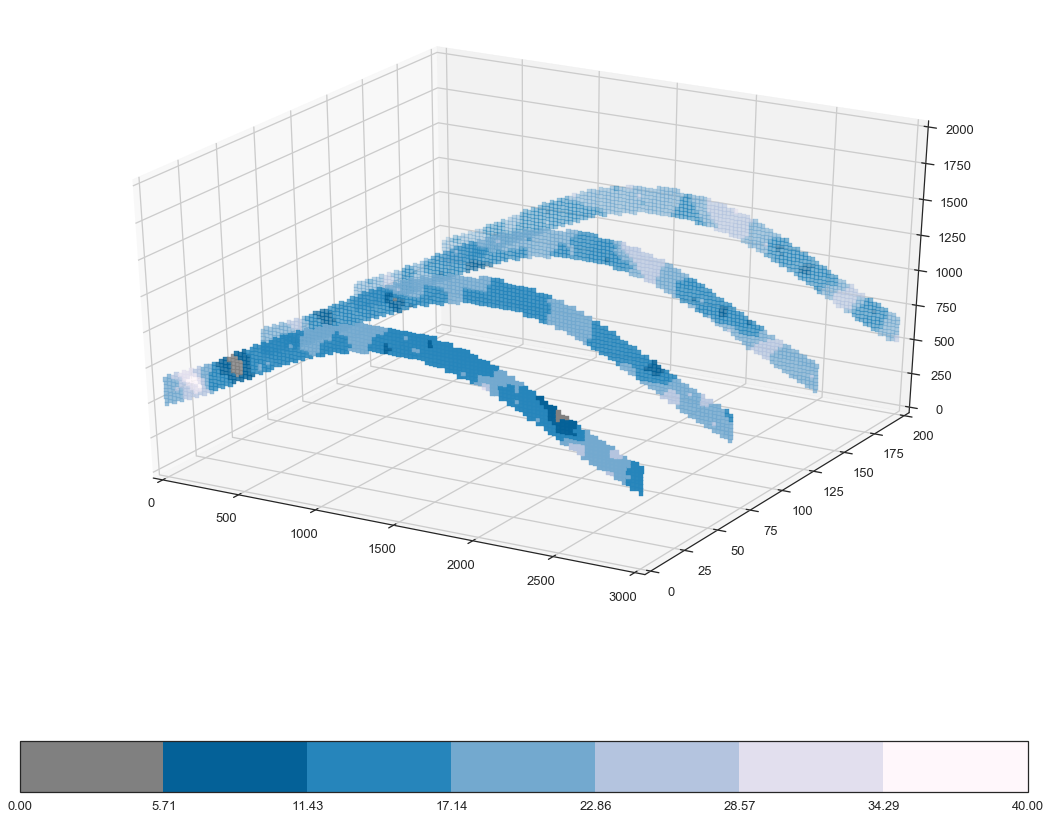

In [33]:
fig = plt.figure(figsize=(14, 12))
ax = Axes3D(fig)

ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
a = ax.scatter3D(xs=coord3d_aux[0],ys=coord3d_aux[1],zs=coord3d_aux[2], c=result2[1], s=20, marker=',', cmap=cmap, norm=norm)
# b = ax.scatter3D(xs=data.X,ys=data.Y,zs=data.Z, c=data.Property, s=50, marker='o', cmap=cmap, norm=norm, linewidths=1, edgecolors='black')

fig.colorbar(a, orientation='horizontal')